<a href="https://colab.research.google.com/github/dustoff06/EcoMod/blob/Day-4-Files/Day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4

# Forecasting Economic Time Series Using RNNs, GRUs, and LSTMs

[Discussion]("https://towardsdatascience.com/understanding-recurrent-neural-networks-the-prefered-neural-network-for-time-series-data-7d856c21b759")

# Recurrent Neural Networks (RNNs)
Recurrent Neural Networks (RNNs) are a class of neural networks that are designed to recognize patterns in sequences of data, such as time series, natural language, and more. Unlike traditional neural networks, RNNs have connections that form directed cycles, allowing them to maintain a memory of previous inputs. This makes them particularly well-suited for tasks where the order of data is crucial.

## Basic Structure:

###Input Layer:
Takes in the sequential data.
###Hidden Layer:
Processes the input and maintains a state that is passed through time.
###Output Layer:
Produces the output for each time step.
###Recurrent Connections:
In a traditional feedforward neural network, the connections between the nodes do not form cycles.In an RNN, there are connections that loop back from the hidden layer to itself, allowing information to persist.

###Unfolding in Time:

An RNN can be conceptually unfolded in time to represent the sequence of operations. Each time step in the sequence has its own set of inputs, hidden states, and outputs.

###Applications: Stock prices, GDP growth, unemployment rates.


### Types of RNNs
####Vanilla RNN:

Basic form of RNN as described above.
Prone to issues like vanishing and exploding gradients.
####Long Short-Term Memory (LSTM):

Designed to handle long-term dependencies.
Incorporates gates (input, forget, and output gates) to control the flow of information.

####Gated Recurrent Unit (GRU):
Simplified version of LSTM with fewer gates (reset and update gates).


# Gated Recurrent Units (GRUs)
Gated Recurrent Units (GRUs) are a type of Recurrent Neural Network (RNN) that are designed to address some of the limitations of traditional RNNs, particularly the vanishing gradient problem. GRUs achieve this through the use of gating mechanisms that control the flow of information, making them capable of capturing long-term dependencies more effectively than simple RNNs. Here, we'll delve into the architecture, working mechanism, and key advantages of GRUs.

##Architecture of GRUs
The architecture of a GRU includes two main gates: the reset gate and the update gate. These gates determine what information should be passed to the output and what should be discarded. Unlike Long Short-Term Memory (LSTM) units, GRUs do not have a separate cell state but instead operate directly on the hidden state.

##Components of a GRU
###Reset Gate:
Determines how much of the past information to forget.
###Update Gate:
Determines how much of the current input and past hidden state to use in updating the hidden state.
###Candidate Hidden State:
The new hidden state candidate computed using the reset gate.

If the update gate is close to 1, the hidden state is mostly updated with the new candidate; if it’s close to 0, the hidden state retains more of its previous value.
Candidate Hidden State:

The candidate hidden state is computed by considering the reset gate's influence, which allows the model to disregard parts of the past that are deemed irrelevant.

New Hidden State is a combination of the previous hidden state and the candidate hidden state, controlled by the update gate.

Advantages of GRUs
Simpler Architecture:

GRUs have a simpler architecture compared to LSTMs, with fewer gates and no separate cell state. This makes them easier to implement and faster to compute.
Efficient Memory Usage:

Due to their simpler structure, GRUs often require less memory and computational resources compared to LSTMs.
Effective in Capturing Dependencies:

Despite their simplicity, GRUs are effective in capturing long-term dependencies in sequential data, making them suitable for a wide range of applications.
Reduced Training Time:

The simpler architecture of GRUs can lead to faster training times compared to LSTMs, especially for large datasets.
Applications of GRUs
GRUs are widely used in various applications involving sequential data, including:

Natural Language Processing:

Machine translation, text generation, sentiment analysis.
Time Series Prediction:

Stock price forecasting, weather prediction, economic indicators.
Speech Recognition:

Transcribing spoken language into text.
Anomaly Detection:

Identifying unusual patterns in data streams.

#Long Short-Term Memory (LSTM) Networks

LSTM networks consist of a series of LSTM cells, each of which contains several key components:

##Cell State:
The long-term memory of the network.
##Hidden State:
The short-term memory or output of the network at each time step.

##Gates:
Mechanisms that control the flow of information into and out of the cell state. These include the forget gate, input gate, and output gate.

##Components of an LSTM Cell
###Forget Gate:
Decides what information to discard from the cell state.
###Input Gate:
Decides what new information to store in the cell state.
###Candidate Cell State:
The new candidate values to be added to the cell state.
###Output Gate:
Decides what part of the cell state to output.

# Example: Forecasting
Step 1: Data Preparation
We'll use % change in GDP quarter by quarter.

In [91]:
#!pip install fredapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
from fredapi import Fred
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
fred = Fred(api_key='
df = fred.get_series('UNRATENSA')
df=pd.DataFrame(df, columns=['y'])
df.index = pd.to_datetime(df.index)
df.head()

,y
1948-01-01,4.0
1948-02-01,4.7
1948-03-01,4.5
1948-04-01,4.0
1948-05-01,3.4


# Plot

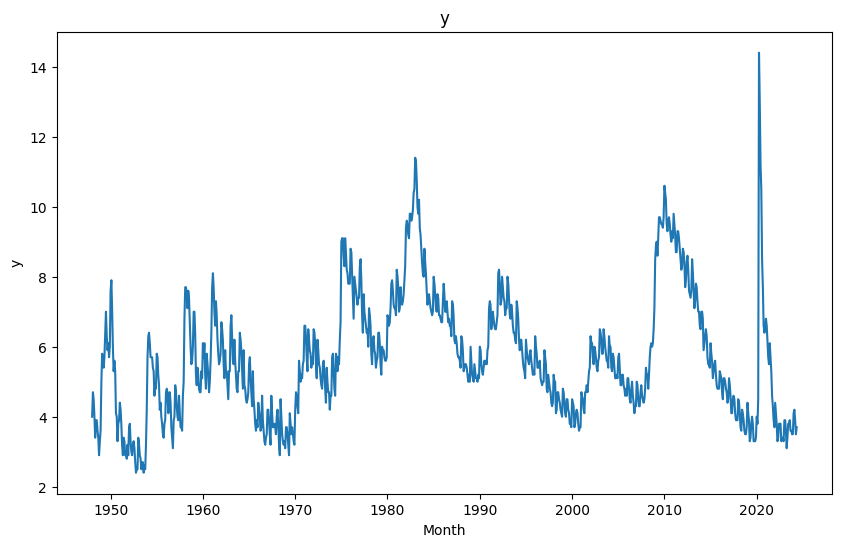

In [92]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['y'])
plt.title('y')
plt.xlabel('Month')
plt.ylabel('y')
plt.show()

# Data Preparation

In [93]:
df["y"].shape

(917,)

In [94]:


# Normalizing the data
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df['y'].values.reshape(-1, 1)) #force to 1 column

# Preparing data for RNN/GRU/LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12 # Number of previous periods used to forecast, hyperparameter
X, Y = create_dataset(df.values, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f'Train size: {train_size}, Test size: {test_size}')


Train size: 607, Test size: 299


# Models

In [95]:
# Building RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, return_sequences=False, input_shape=(time_step, 1)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Training RNN model
rnn_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)


In [96]:
# Building GRU model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=False, input_shape=(time_step, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Training GRU model
gru_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)


In [97]:
# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Training LSTM model
lstm_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)


# ETS & SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


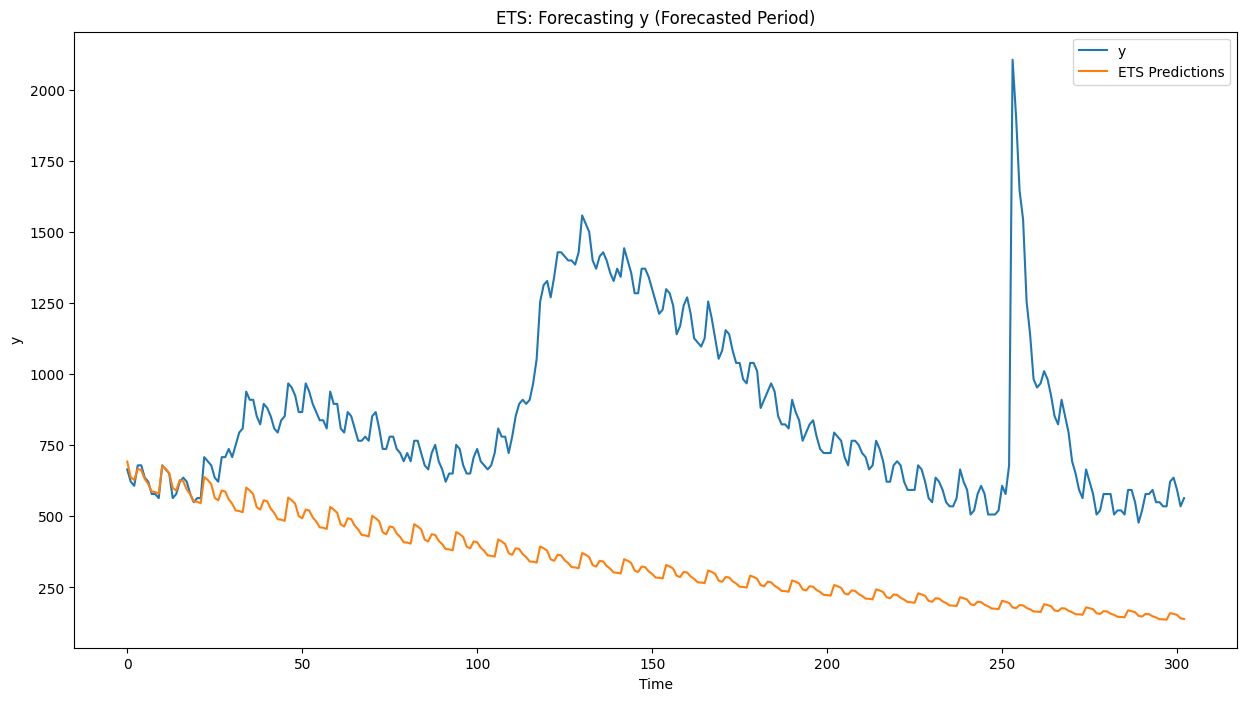

ETS - MSE: 364596.3874707994, MAE: 513.533724965951


In [100]:
# Reverting the normalization for ETS and SARIMA
df['y'] = scaler.inverse_transform(df[['y']])

# Splitting into train and test sets for ETS and SARIMA
train_size_ets_sarima = int(len(df) * 0.67)
train_data = df['y'][:train_size_ets_sarima]
test_data = df['y'][train_size_ets_sarima:]

# ETS model
ets_model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()
ets_predictions = ets_model.forecast(len(test_data))

# Plotting ETS results
plt.figure(figsize=(15, 8))

plt.plot(test_data.values, label='y')
plt.plot(ets_predictions.values, label='ETS Predictions')
plt.title('ETS: Forecasting y (Forecasted Period)')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

plt.show()

# Evaluate ETS
ets_mse = mean_squared_error(test_data, ets_predictions)
ets_mae = mean_absolute_error(test_data, ets_predictions)
print(f"ETS - MSE: {ets_mse}, MAE: {ets_mae}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


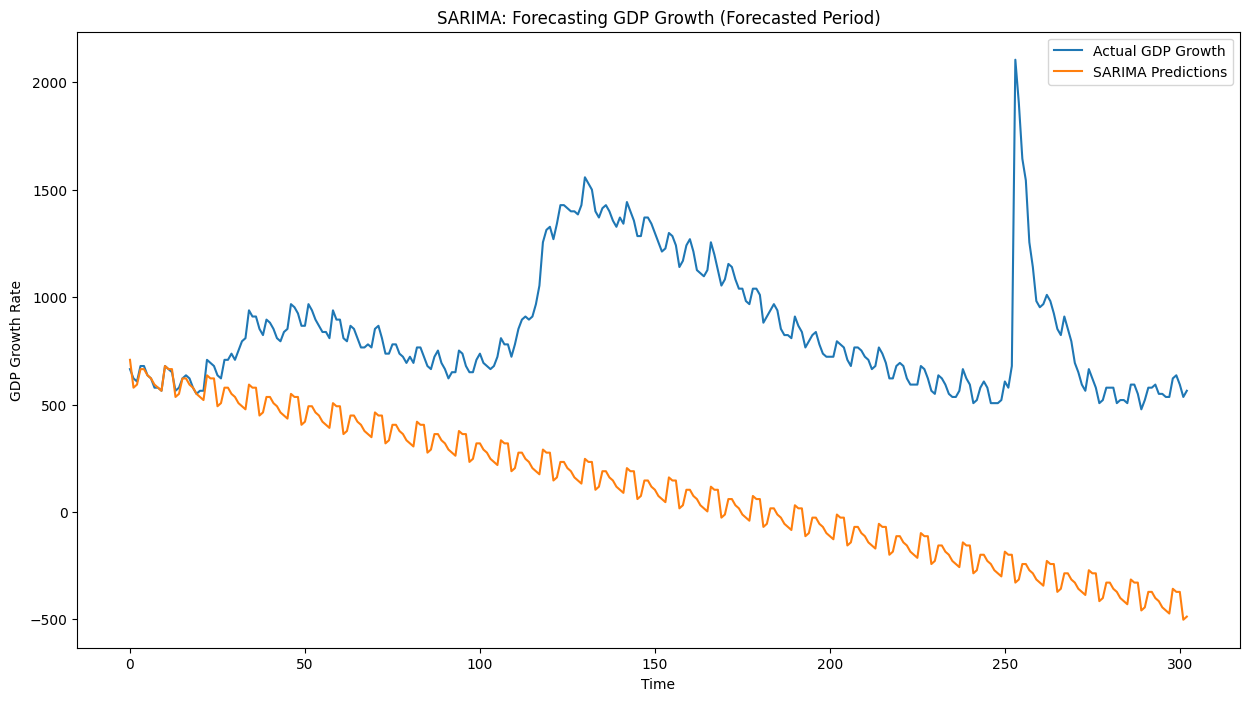

SARIMA - MSE: 717341.7314851473, MAE: 744.6653465346529


In [102]:
# SARIMA model
sarima_model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12)).fit(disp=False)
sarima_predictions = sarima_model.forecast(len(test_data))

# Plotting SARIMA results
plt.figure(figsize=(15, 8))

plt.plot(test_data.values, label='Actual y')
plt.plot(sarima_predictions.values, label='SARIMA Predictions')
plt.title('SARIMA: Forecasting y (Forecasted Period)')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

plt.show()

# Evaluate SARIMA
sarima_mse = mean_squared_error(test_data, sarima_predictions)
sarima_mae = mean_absolute_error(test_data, sarima_predictions)
print(f"SARIMA - MSE: {sarima_mse}, MAE: {sarima_mae}")

# Forecast

10/10 [==============================] - 0s 5ms/step
RNN - MSE: 0.003973923623438787, MAE: 0.02687817480219912


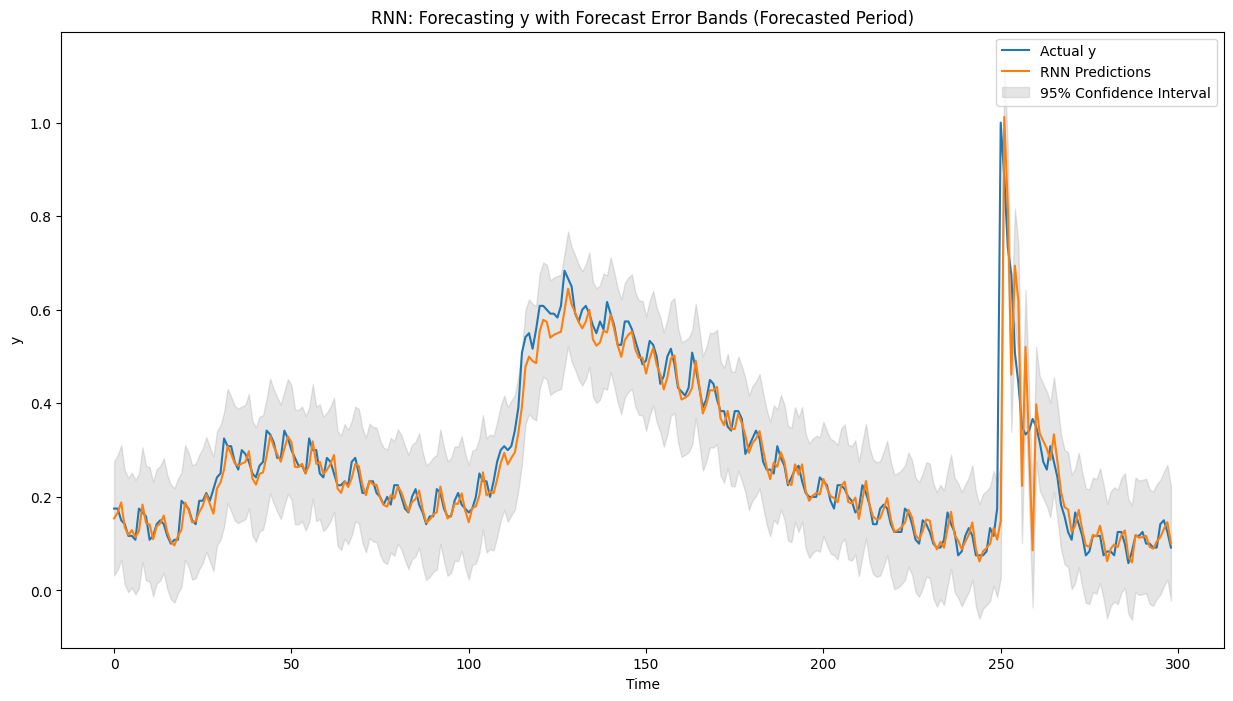

10/10 [==============================] - 0s 7ms/step
GRU - MSE: 0.0034306734380405153, MAE: 0.02854594865869918


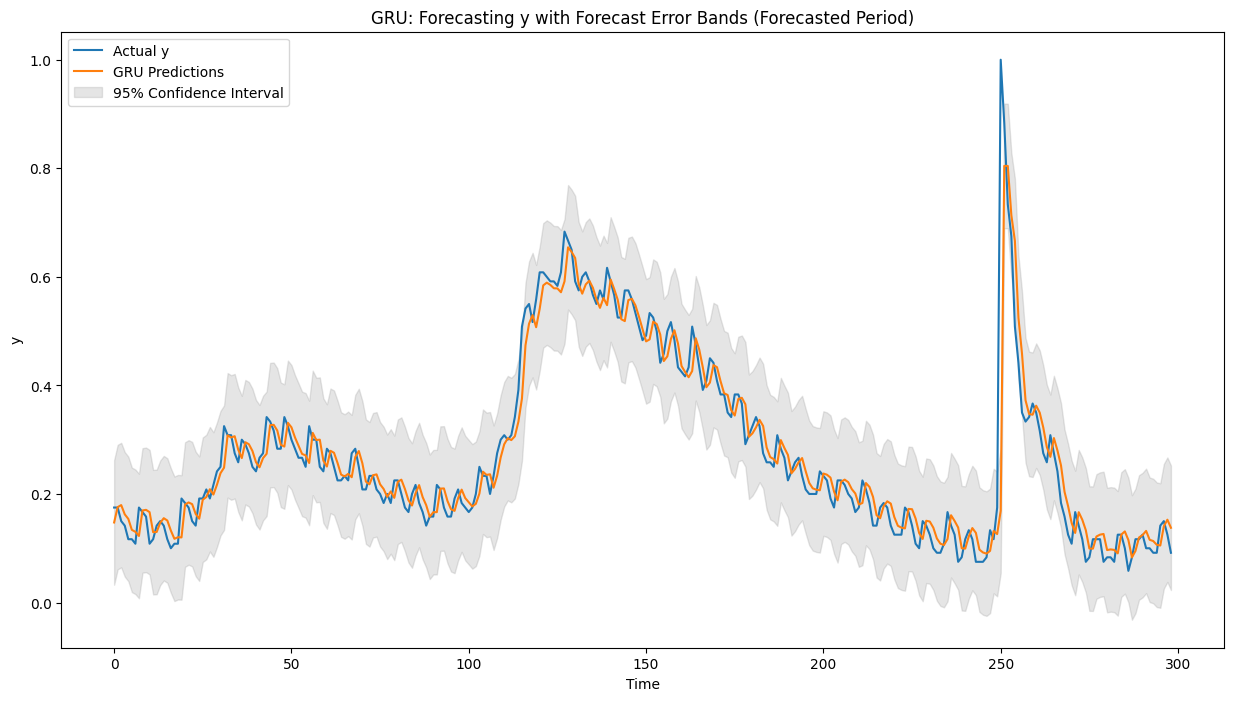

10/10 [==============================] - 0s 11ms/step
LSTM - MSE: 0.004677496927458202, MAE: 0.03417600111219796


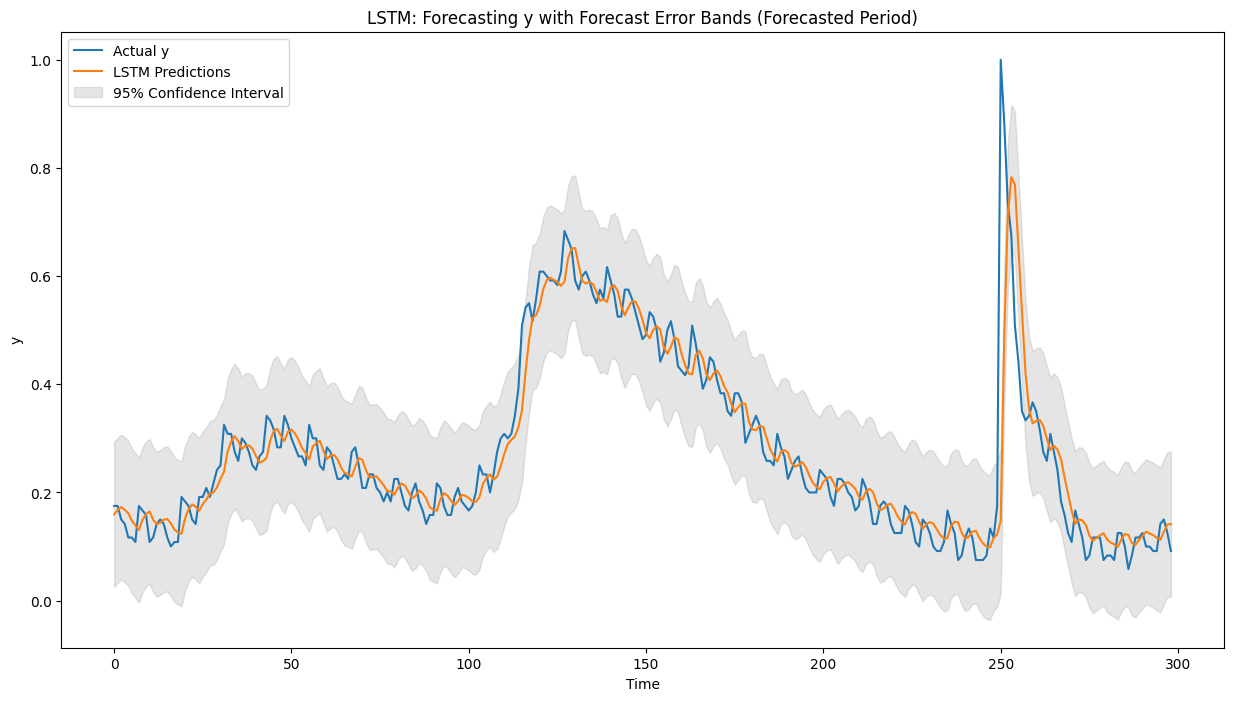

TypeError: Cannot convert input [[692.28067189 637.29629088 627.27714318 666.6658536  662.38988291
 631.56631765 613.27192035 587.00674207 585.21055635 579.98607453
 677.9559664  666.78712619 651.80155949 600.03223131 590.59892434
 627.6844937  623.65854804 594.63730172 577.41261645 552.6832186
 550.99205964 546.0730643  638.31444977 627.79867522 613.68934624
 564.94707998 556.06535838 590.98245621 587.1919161  559.86760331
 543.65008175 520.366664   518.77439068 514.14301938 600.99085631
 591.0899613  577.80563457 531.91343152 523.55104293 556.42646434
 552.8575651  527.13096257 511.86171374 489.93972658 488.44055684
 484.0799916  565.84965215 556.52768338 544.02011928 500.81133022
 492.93790815 523.89103426 520.5308161  496.30850233 481.93207871
 461.29191642 459.88040631 455.77481252 532.76322839 523.98633481
 512.21011439 471.52783445 464.11478799 493.25801947 490.09428036
 467.28829641 453.75249263 434.31920421 432.99022807 429.12469702
 501.61143768 493.34774759 482.26010764 443.9566065  436.97701651
 464.41618172 461.43743312 439.9649632  427.22062644 408.92364342
 407.67237532 404.03287003 472.28115793 464.50066325 454.06134102
 417.99752645 411.42604783 437.26078712 434.45621223 414.23928297
 402.24013448 385.01301468 383.83491087 380.40821514 444.66588157
 437.34032884 427.51141581 393.55632862 387.36909823 411.69322577
 409.0526403  390.01783756 378.72030463 362.50049089 361.3912733
 358.1649437  418.66532871 411.76811651 402.51392078 370.54425923
 364.71880925 387.62065371 385.13446884 367.21267121 356.57572888
 341.30432189 340.25996259 337.2222833  394.18508307 387.69116543
 378.97808206 348.87775411 343.3929305  364.95565575 362.61484337
 345.74097108 335.72599322 321.34753764 320.36424423 317.50418446
 371.13624907 365.02204451 356.81843352 328.47813529 323.31402089
 343.61592808 341.41198794 325.52476659 316.09538562 302.5576687
 301.63187053 298.93904449 349.43512906 343.67843495 335.95450641
 309.27132525 304.40916752 323.52397934 321.44890823 306.49064625
 297.6126211  284.86648306 283.99481827 281.45944745 329.00291935
 323.58283129 316.31053717 291.18757794 286.60972084 304.60684925
 302.65311193 288.56949111 280.21058283 268.2097384  267.38904168
 265.00191935 309.76542408 304.66226001 297.81519227 274.16122551
 269.85104538 286.7958437  284.95634553 271.69622375 263.82607848
 252.52694876 251.75423992 249.50669767 291.65278577 286.84801448
 280.40130925 258.13043986 254.07228506 270.02628525 268.29434641
 255.80957195 248.3996107  237.76116494 237.03363801 234.91751431
 274.59923166 270.07540549 264.00565272 243.03700808 239.21614216
 254.23727828 252.60660957 240.85184622 233.87516105 223.85876767
 223.17378078 221.1813913  258.54283486 254.28352636 248.56868485
 228.82612113 225.22866931 239.37148788 237.83616781 226.7687303
 220.19998663 210.76927293 210.12433866 208.2484484  243.42528948
 239.41503174 234.03434908 215.44617474 212.05907352 225.37493164
 223.92938497 213.50908389 207.32442854 198.44514857 197.83792498
 196.07172197 229.19169889 225.41592939 220.3498666  202.84858206
 199.6595318  212.19678358 210.83576108 201.024757   195.2017315
 186.84164178 186.26992383 184.60699445 215.7903764  212.23538411
 207.46554471 190.98759722 187.98501746 199.78918966 198.50774902
 189.27041507 183.78787416 175.91661653 175.37832814 173.81263375
 203.17265752 199.82553313 195.33459631 179.82014921 176.99313662
 188.10709396 186.90058185 178.20337432 173.04140915 165.63040058
 165.12358704 163.64944211 191.2927233  188.14131235 183.91297009
 169.30568545 166.64397426 177.10807505 175.97211025 167.7834468
 162.92331264 155.94564138 155.46846231 154.08051374 180.10743392
 177.14029262 173.15919045 159.40602459 156.89994928 166.752192
 165.68264946 157.97279445 153.39684259 146.8271705  146.3778931
 145.07110081 169.57617203 166.78252574 163.03420702 150.0852178
 147.725678   157.00183929 155.99483517 148.73579165 144.42740536
 138.24187587 137.81886866 136.58848728 159.66069524 157.03039935
 153.50125274 141.30941826 139.08784574]] of type <class 'numpy.ndarray'> to Timestamp

In [114]:
# Evaluating and plotting function
def evaluate_and_plot(model, X_test, Y_test, model_name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}")

    residuals = Y_test - predictions.flatten()
    std_residuals = np.std(residuals)

    plt.figure(figsize=(15, 8))
    plt.plot(Y_test, label='Actual y')
    plt.plot(predictions, label=f'{model_name} Predictions')
    plt.fill_between(range(len(Y_test)), predictions.flatten() - 1.96 * std_residuals, predictions.flatten() + 1.96 * std_residuals, color='gray', alpha=0.2, label='95% Confidence Interval')
    plt.title(f'{model_name}: Forecasting y with Forecast Error Bands (Forecasted Period)')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    return mse, mae

# Evaluate and plot RNN
rnn_mse, rnn_mae=evaluate_and_plot(rnn_model, X_test, Y_test, "RNN")

# Evaluate and plot GRU
gru_mse, gru_mae=evaluate_and_plot(gru_model, X_test, Y_test, "GRU")

# Evaluate and plot LSTM
lstm_mse, lstm_mae=evaluate_and_plot(lstm_model, X_test, Y_test, "LSTM")

metrics_data = {
    'Model': ['RNN', 'GRU', 'LSTM', 'ETS', 'SARIMA'],
    'MSE': [rnn_mse, gru_mse, lstm_mse, ets_mse, sarima_mse],
    'MAE': [rnn_mae, gru_mae, lstm_mae, ets_mae, sarima_mae]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df
